In [1]:
import json
import os
import re
import time
import urllib.request

import pandas as pd
import torch
from tqdm import tqdm
from tqdm import trange
from transformers import AutoTokenizer, AutoModel


In [2]:
path = 'knn_labeled.parquet.gzip'
df = pd.read_parquet(path, engine='pyarrow')

In [3]:
def train_val_split(df_labeled, train_share=0.8, use_val=True):
    last_train = df_labeled.reset_index()['date'].quantile(train_share)
    if use_val:
        df_labeled_train = df_labeled[df_labeled.index <= last_train]
    else:
        df_labeled_train = df_labeled
    df_labeled_val = df_labeled[df_labeled.index > last_train]
    return df_labeled_train, df_labeled_val

In [4]:
df_labeled = df[df['label_knn']!=-1]
df_train, df_val = train_val_split(df_labeled)

In [5]:
df_train['label_knn'].value_counts()

1    8124
0    7868
Name: label_knn, dtype: int64

In [6]:
df.shape

(4699045, 19)

In [7]:
train_texts = df_train['tweet_cleaned'].to_list()
val_texts = df_val['tweet_cleaned'].to_list()

In [8]:
train_labels = df_train['label_knn'].to_list()
val_labels = df_val['label_knn'].to_list()

In [9]:
train_texts

['Stifel today raised its price target on Microsoft COMPANY_CASHTAG to $305 from $285 while maintaining its Buy rating',
 'Cramer on COMPANY_CASHTAG “If you’re debating whether a company is a growth stock it’s probably not a growth stock 🔥🔥🔥',
 '1/2 Now that Vixperation has passed there is a window here for a surprise selloff the next few days in front of FOMC and the mega caps reporting Price action in COMPANY_CASHTAG today may be an early tell that not all is well in mega land.',
 'COMPANY_CASHTAG appears to have entered growth purgatory As I said yesterday high P/E stocks with volume growth of +1.8 don’t trade at 40x EPS Even with new video games based on The Witcher and House of Cards on the way in a year or two',
 'Very excited for COMPANY_CASHTAG to rally 5-10 as pod shops expecting a Bigly miss on sub+outlook cover their crowded short and represent 70-80 of volume today Play stupid games win stupid prizes Unless you’re an energy guy Then you never win and the game is the stupide

In [10]:
num_labels = 2

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

drop=0.1
kwargs = {'hidden_dropout_prob': drop, 'attention_probs_dropout_prob': drop, 'classifier_dropout': drop, }
model_name = "cardiffnlp/twitter-roberta-base-dec2021"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, **kwargs)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-dec2021 were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-dec2021 and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.ou

In [12]:
train_encodings = tokenizer(train_texts,  truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [13]:
len(val_texts)

3998

In [14]:
import torch


class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)

In [15]:
import sklearn.metrics
import numpy as np

def simple_accuracy(preds, labels):
    return (preds == labels).mean().item()

def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=-1)
    acc = simple_accuracy(preds, labels)
    f1 = sklearn.metrics.f1_score(y_true=labels, y_pred=preds)
    return {
        "accuracy": acc,
        "f1": f1,
    }

In [16]:
from transformers import TrainingArguments
from transformers import Trainer

training_args = TrainingArguments(
    overwrite_output_dir=True,
    output_dir='./results',  # output directory
    num_train_epochs=1,  # total number of training epochs
    per_device_train_batch_size=64,  # batch size per device during training
    per_device_eval_batch_size=512,  # batch size for evaluation
    warmup_steps=100,  # number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # strength of weight decay
    logging_dir='./logs',  # directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',
    save_total_limit = 5, # Only last 5 models are saved. 
    eval_steps=50,
    save_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    learning_rate=2e-5,
)

trainer = Trainer(
    model=model,  # the instantiated 🤗 Transformers model to be trained
    args=training_args,  # training arguments, defined above
    train_dataset=train_dataset,  # training dataset
    eval_dataset=val_dataset,  # evaluation dataset
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 15992
  Num Epochs = 1
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 63
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy,F1
50,0.390400,0.259405,0.895198,0.890914


***** Running Evaluation *****
  Num examples = 3998
  Batch size = 2048
Saving model checkpoint to ./results/checkpoint-50
Configuration saved in ./results/checkpoint-50/config.json
Model weights saved in ./results/checkpoint-50/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-50 (score: 0.8909138245248632).


TrainOutput(global_step=63, training_loss=0.523125388792583, metrics={'train_runtime': 98.6017, 'train_samples_per_second': 162.188, 'train_steps_per_second': 0.639, 'total_flos': 4207671997317120.0, 'train_loss': 0.523125388792583, 'epoch': 1.0})

In [17]:
test_texts = df['tweet_cleaned'].to_list()
test_labels = np.zeros(len(test_texts), dtype=np.int64)

In [18]:
# from tqdm import trange

# def tokenize_data(texts, tokenizer, batch_size=65536):
#     all_encodings = {k:[] for k in val_encodings}
#     for i in trange(0, len(texts), batch_size):
#         encoded_input = tokenizer(test_texts[i:i + batch_size],  truncation=True, padding='max_length')
#         for k in encoded_input:
#             all_encodings[k] += encoded_input[k]
#     return all_encodings
# test_encodings = tokenize_data(test_texts, tokenizer)

In [19]:
# test_dataset = TweetDataset(test_encodings, test_labels)

In [20]:
# import scipy

# predictions = trainer.predict(test_dataset)
# preds = pred.predictions
# probs = scipy.special.softmax(pred, axis=-1)

In [21]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

@torch.no_grad()
def get_logits(texts, tokenizer, model, device='cpu', batch_size=128):
    logits = []
    for i in trange(0, len(texts), batch_size):
        encoded_input = tokenizer(texts[i:i + batch_size], return_tensors='pt',
                                  padding=True, truncation=True).to(device)
        output = model(**encoded_input)
        logits.append(output.logits.cpu())
    return torch.cat(logits, dim=0)


In [22]:
import torch
model = torch.nn.DataParallel(trainer.model)
logits = get_logits(test_texts, tokenizer, model, device=device, batch_size=1024)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2295/2295 [33:41<00:00,  1.14it/s]


In [23]:
probs = torch.softmax(logits, dim=-1)

In [24]:
df['prob'] = probs[:,-1].cpu().numpy()

<AxesSubplot:>

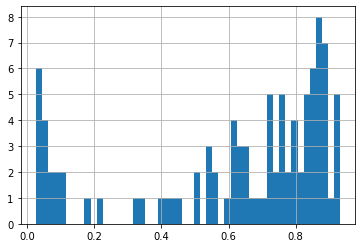

In [25]:
df[df['original_val']==1].prob.hist(bins=50)

<AxesSubplot:>

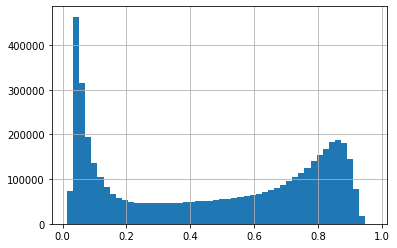

In [26]:
df.prob.hist(bins=50)

In [27]:
t = df.prob.quantile(1-10000/len(df))
t

0.9327251318922208

In [28]:
pd.set_option('display.max_rows', 500)

In [29]:
df[df['prob']>t].sort_values('prob').head(250)

,cashtags,clean_tweet,day,id,language,month,nlikes,nreplies,nretweets,symbol,tweet,urls,username,year,company_name,tweet_cleaned,closest_embedding,label_knn,original_val,prob
date,,,,,,,,,,,,,,,,,,,,


In [30]:
df[(df['original_val']==1) & (df['prob']>t)].shape

(0, 20)

In [ ]:
df.to_csv('class_labeled.csv.gzip', compression='gzip')